## Simple GCN

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(root)

In [3]:
import torch
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

import scripts.data.dataset as ds
from scripts.model.simple_gcn import SimpleGCN
from scripts.train.train import train_one_epoch
from scripts.evaluate.evaluate import evaluate, compare_ytrue_ypred

In [4]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print("Using device:", device)

Using device: cpu


### Preparing the dataset

Download the dataset

In [5]:
dataset = ds.load_qm9_dataset(root=f"{root}/data/QM9")
ds.describe_dataset(dataset)

Dataset: QM9(130831):
[====================]
Number of graphs: 130831
Number of features: 11
Number of classes: 19

First node data:
[====================]
Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5])
Number of nodes: 5
Number of edges: 8
Average node degree: 1.60
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Split the dataset into training and test sets

In [6]:
train_dataset, test_dataset = ds.split_dataset(dataset, training_perc=0.9)

Number of training graphs: 117747
Number of test graphs: 13084


Normalize the target property in the training set

In [7]:
target_idx = 11
train_mean, train_std = ds.normalize_train_set(train_dataset, target_idx=target_idx)
train_mean = train_mean.to(device)
train_std = train_std.to(device)

Target statistics - Mean: 31.6171, Std: 4.0676


Create the DataLoaders for the training and test sets

In [8]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Training

In [13]:
# Model, optimizer, loss, scheduler
model = SimpleGCN(input_channels=dataset.num_features, hidden_channels=128).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = torch.nn.L1Loss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)

# Training loop with early stopping and checkpointing
max_epochs = 500
patience = 20
min_delta = 1e-4
best_val = float('inf')
epochs_no_improve = 0
save_path = f"{root}/models/simple_gcn.pt"

print("Starting training...")
for epoch in range(1, max_epochs + 1):

    train_loss = train_one_epoch(
        model, train_loader, optimizer, criterion, device,
        train_mean, train_std, target_idx, model_type="gcn")
    
    train_mae = evaluate(
        model, train_loader, device, train_mean,
        train_std, target_idx, model_type="gcn")
    
    val_mae = evaluate(
        model, test_loader, device, train_mean,
        train_std, target_idx, model_type="gcn")
    
    scheduler.step(val_mae)

    # Check for improvement and checkpoint
    if val_mae < best_val - min_delta:
        best_val = val_mae
        epochs_no_improve = 0
        # torch.save(model.state_dict(), save_path)
        improved = " *"
    else:
        epochs_no_improve += 1
        improved = ""

    if epoch % 5 == 0 or epochs_no_improve == 0:
        print(f"[*] Epoch {epoch:03d}  Train loss: {train_loss:.4f}  Train MAE: {train_mae:.4f}  Val MAE: {val_mae:.4f}{improved}")

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch} (no val MAE improvement for {patience} epochs).")
        break


# Load best model for final evaluation
model.load_state_dict(torch.load(save_path))
final_val = evaluate(
        model, test_loader, device, train_mean,
        train_std, target_idx, model_type="gcn")

print(f"Best validation MAE: {best_val:.4f}")
print(f"Final evaluated MAE: {final_val:.4f}")
print(f"Test set mean: {train_mean:.4f}, std: {train_std:.4f}")
print(f"Relative MAE: {(best_val/train_std.abs()):.4f} standard deviations")

# Compare to baseline (predicting mean)
baseline_mae = train_std.abs().item()
print(f"Baseline MAE (predicting mean): {baseline_mae:.4f}")
print(f"Improvement over baseline: {(baseline_mae/best_val):.2f}x")

Starting training...


KeyboardInterrupt: 

### Testing the performance

In [11]:
model = SimpleGCN(input_channels=dataset.num_features, hidden_channels=128)
model.load_state_dict(torch.load(f'{root}/models/simple_gcn.pt'))
model.to(device)

test_mae = evaluate(
        model, test_loader, device, train_mean,
        train_std, target_idx, model_type="gcn")

print(f"Test set MAE: {test_mae:.4f}")
print(f"Test set mean: {train_mean:.4f}, std: {train_std:.4f}")
print(f"Relative MAE: {(test_mae/train_std.abs()):.4f} standard deviations")

Test set MAE: 1.2053
Test set mean: 31.6171, std: 4.0676
Relative MAE: 0.2963 standard deviations


R² score on test set: 0.7047


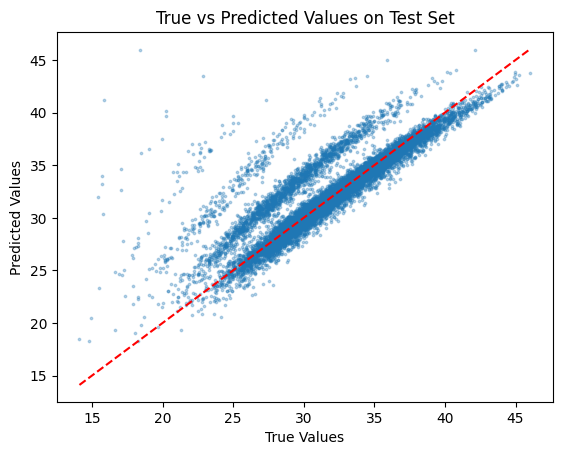

In [12]:
ytrue, ypred = compare_ytrue_ypred(
        model, test_loader, device, train_mean,
        train_std, target_idx, model_type="gcn")
ytrue = torch.cat(ytrue).cpu().numpy()
ypred = torch.cat(ypred).cpu().numpy()

# Calculate R² score
r2 = r2_score(ytrue, ypred)
print(f"R² score on test set: {r2:.4f}")

# Plot true vs predicted valuesS
plt.scatter(ytrue, ypred, alpha=0.3, s=3)
plt.plot([ytrue.min(), ytrue.max()], [ytrue.min(), ytrue.max()], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values on Test Set")
plt.show()